In [ ]:
# !pip install --user pytorch-lightning

In [11]:
%rm -rf lightning_logs
import torch # Pytorch主套件
from torch import nn # 神經網路層相關子套件
from torch.nn import functional as F
from torch.utils import data # Data讀取相關子套件 

from torchvision.datasets import MNIST # MNIST資料集
from torchvision import transforms as trans # 圖形前處理子套件

import pytorch_lightning as pl # Lightning 主套件

## Module class

In [41]:
## ---最簡單的Lightning Module---
class LitModel(pl.LightningModule):
    # ---初始化---
    def __init__(self):
        super().__init__()
        # ---至少要放一個網路(把結構放在這邊，Sequential或者layers都可以)---
        self.net=nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    # ---網路走法(如果有skipping, concatenate, 還有tensor操作在這邊)---    
    def forward(self,x):
        x=x.view(x.shape[0],-1)
        return self.net(x)
    
    # ---每個training batch要做的事---    
    def training_step(self, batch, batch_idx):
        # ---分開data, label---
        x, y = batch
        # ---data進網路---
        y_hat = self(x)
        # ---prediction跟y算loss---
        loss = F.cross_entropy(y_hat, y) # cross_entropy裡面包含softmax計算
        
        return loss
    
    # ---Optimizer放這邊---
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [42]:
BATCH_SIZE=1024
EPOCHS=2

## Data Loader

In [ ]:
# ---讀取dataset---
MNIST_train=MNIST(".", download=True,train=True, transform=trans.ToTensor())

# ---將dataset放進dataloader(平行執行, 分batch_size, shuffle等功能)---
train_loader = data.DataLoader(MNIST_train,batch_size=BATCH_SIZE,shuffle=True)

## Trainer

In [14]:
# ---建立Trainer(負責model fitting, 紀錄訓練內容)---
trainer = pl.Trainer(max_epochs=EPOCHS)
# ---建立Model class---
model = LitModel()

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1295: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"


## Training

In [15]:
'''訓練開始'''
trainer.fit(model,train_loader)


  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 101 K 
------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

## Logging

In [43]:
from pytorch_lightning.metrics.functional import accuracy

class ModelWithLog(LitModel):
    def __init__(self):
        super().__init__()
    def training_step(self, batch, batch_idx):
        ### --------------之前就有的-------------
        # ---分開data, label---
        x, y = batch
        # ---data進網路---
        y_hat = self(x)
        # ---prediction跟y算loss---
        loss = F.cross_entropy(y_hat, y) # cross_entropy裡面包含softmax計算
        
        
        ### --------------紀錄用區段-------------
        # ---算acc---
        acc=accuracy(y_hat, y)
        # ---記錄起來---
        self.log("train_loss",loss,prog_bar=True,logger=True)
        self.log("train_acc",acc,prog_bar=True,logger=True)
        return loss

In [19]:
model = ModelWithLog()
trainer.fit(model,train_loader)


  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 101 K 
------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 58it [00:00, ?it/s]

## Testing

In [44]:
class ModelWithTest(ModelWithLog):
    def __init__(self):
        super().__init__()
    ## ---跟trainin step基本一樣---
    def test_step(self, batch, batch_idx):
        ### --------------之前就有的-------------
        # ---分開data, label---
        x, y = batch
        # ---data進網路---
        y_hat = self(x)
        # ---prediction跟y算loss---
        loss = F.cross_entropy(y_hat, y) # cross_entropy裡面包含softmax計算
        
        acc=accuracy(y_hat, y)
        # ---記錄起來---
        self.log("test_loss",loss,prog_bar=True,logger=True)
        self.log("test_acc",acc,prog_bar=True,logger=True)

In [45]:
'''先train'''
model = ModelWithTest()
trainer.fit(model,train_loader)


  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 101 K 
------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 58it [00:00, ?it/s]

## Testing

In [33]:
# ---讀取dataset---
MNIST_test=MNIST(".", download=True,train=False, transform=trans.ToTensor()) # testing dataset

# ---將dataset放進dataloader(平行執行, 分batch_size, shuffle等功能)---
test_loader = data.DataLoader(MNIST_test,batch_size=BATCH_SIZE*2,shuffle=True) # testing loader

In [46]:
trainer.test(model,test_loader)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:377: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f"Your {mode}_dataloader has `shuffle=True`, it is best practice to turn"
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9535999894142151, 'test_loss': 0.14951574802398682}
--------------------------------------------------------------------------------


[{'test_loss': 0.14951574802398682, 'test_acc': 0.9535999894142151}]

## Saving

In [35]:
trainer.save_checkpoint("checkpoints")

## 提高整合性

In [73]:
## ---最簡單的Lightning Module---
class Model(pl.LightningModule):
    # ---初始化---
    def __init__(self):
        super().__init__()
        # ---至少要放一個網路(把結構放在這邊，Sequential或者layers都可以)---
        self.net=nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    # ---網路走法(如果有skipping, concatenate, 還有tensor操作在這邊)---    
    def forward(self,x):
        x=x.view(x.shape[0],-1)
        return self.net(x)
    
    # ---每個training batch要做的事---    
    def training_step(self, batch, batch_idx,flag="train"):
        # ---分開data, label---
        x, y = batch
        
        # ---data進網路---
        y_hat = self(x)
        
        # ---prediction跟y算loss,acc---
        loss = F.cross_entropy(y_hat, y) # cross_entropy裡面包含softmax計算
        acc=accuracy(y_hat, y)
        
        # ---記錄起來---
        self.log_dict({flag+"_loss":loss,flag+"_acc":acc},prog_bar=True,logger=True)
        return loss
    
    # ---Optimizer放這邊---
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)
    
    # ---重複利用step function---
    def test_step(self, batch, batch_idx):
        self.training_step(batch, batch_idx,flag="test")
    def validation_step(self, batch, batch_idx):
        self.training_step(batch, batch_idx,flag="val")
    

In [75]:
model = Model()
trainer.fit(model,train_loader)


  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 101 K 
------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 58it [00:00, ?it/s]

In [76]:
trainer.test(model,test_loader)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.953499972820282, 'test_loss': 0.1558782011270523}
--------------------------------------------------------------------------------


[{'test_loss': 0.1558782011270523, 'test_acc': 0.953499972820282}]

## Inference

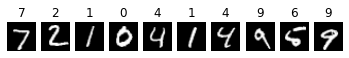

In [77]:
import matplotlib.pyplot as plt

## ---Evaluation mode---
model.eval()

for ii in range(10):
    x=MNIST_test[ii][0]
    y=MNIST_test[ii][1]
    
    # ---關掉gradient 計算---
    with torch.no_grad():
        # ---計算output---
        pred = model(x)
        plt.subplot(1,10,ii+1)
        plt.imshow(x.squeeze(),"gray")
        plt.title(pred.argmax(-1).item())
        plt.axis("off")